In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import yfinance as yf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRFRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import pytz
import plotly.io as pio
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [2]:
xmr = yf.Ticker("XMR-USD XMR-BTC XMR-EUR XMR-CNY")
df = yf.download(tickers = "XMR-USD",
                     period = "max",
                     interval = "1d")
df.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
### Get Gold, Silver and Copper closing prices in our dataframe's date range.

### Define date range
start_Date = df['Date'].min().date()
end_Date = df['Date'].max().date()

def get_precious_metals(tickers: list):
    p_metals_close = []
    for ticker in tickers:
        p_metal = yf.Ticker(f"{ticker}")
        p_metal_hist = p_metal.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
        p_metal_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
        p_metal_hist.reset_index(inplace=True)
        p_metal_hist['Date'] = p_metal_hist['Date'].dt.tz_convert(pytz.UTC)
        p_metal_close=p_metal_hist[['Close']]    
        p_metals_close.append(p_metal_close)
    return p_metals_close

### in order of : Gold >> Silver >> Copper
metals_tickers = ['GC=F', 'SI=F', 'HG=F']
pMetals_closePriceList = get_precious_metals(metals_tickers)

In [4]:
### Combine all 3 precious metals closing prices into a single dataframe named metal_df 

gold_close = pMetals_closePriceList[0]
silver_close = pMetals_closePriceList[1]
copper_close = pMetals_closePriceList[2]

metal_df  = pd.concat([gold_close, silver_close,copper_close], axis=1)
metal_df.columns = ['gold_close', 'silver_close', 'copper_close']
metal_df 

,gold_close,silver_close,copper_close
0,1285.599976,16.943001,3.0800
1,1272.400024,16.844000,3.0695
2,1277.300049,17.023001,3.1115
3,1281.500000,17.052000,3.0600
4,1276.500000,16.950001,3.0490
...,...,...,...
1487,1872.800049,21.957001,3.6140
1488,1869.300049,21.792000,3.5940
1489,1927.400024,22.726999,3.5800
1490,1921.099976,22.610001,3.5870


In [5]:
### Get other crypto coins close price to improve Model performance

def get_other_coins(tickers: list):
    other_coins_close = []
    for ticker in tickers:
        coin = yf.Ticker(f"{ticker}")
        coin_hist = coin.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
        coin_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
        coin_hist.reset_index(inplace=True)
        coin_hist['Date'] = coin_hist['Date'].dt.tz_convert(pytz.UTC)
        coin_close = coin_hist[['Close']]
        other_coins_close.append(coin_close)
    return other_coins_close

### Coins close prices (as a df) will be returned in the order spedified in the coins_tickers list.  
coins_tickers = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'XRP-USD']
coins_close_list = get_other_coins(coins_tickers)

In [6]:
### Create a df for other crypto coins

crypto_df = pd.concat(coins_close_list, ignore_index=True, axis=1)
crypto_df.columns = ['bitcoin_close', 'ethereum_close', 'tether_close', 'bnb_close', 'xrp_close']
crypto_df

,bitcoin_close,ethereum_close,tether_close,bnb_close,xrp_close
0,7143.580078,320.884003,1.008180,1.990770,0.217488
1,6618.140137,299.252991,1.006010,1.796840,0.206483
2,6357.600098,314.681000,1.008990,1.670470,0.210430
3,5950.069824,307.907990,1.012470,1.519690,0.197339
4,6559.490234,316.716003,1.009350,1.686620,0.203442
...,...,...,...,...,...
2164,26862.375000,1552.089478,0.999960,206.036118,0.485699
2165,26861.707031,1555.256836,1.000106,206.601898,0.486775
2166,27159.652344,1558.069824,1.000373,209.742508,0.487846
2167,28519.466797,1600.534302,1.000548,214.823959,0.497977


In [7]:
### Get 'S&P 500' stock market index

sp = yf.Ticker("^GSPC")
sp_hist = sp.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
sp_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
sp_hist.reset_index(inplace=True)
sp_hist['Date'] = sp_hist['Date'].dt.tz_convert(pytz.UTC)
sp_close=sp_hist[['Close']]

In [8]:
### Combine Other Crypto coins and precious metals' dataframes
crypto_metal_df = pd.concat([crypto_df, metal_df, sp_close ], axis=1)

### Assign column names
crypto_metal_df.columns = ['bitcoin_close', 'ethereum_close', 'tether_close', 'bnb_close', 'xrp_close',
                     'gold_close', 'silver_close', 'copper_close','sp_close']
### Fill missing values using interpolate technique
crypto_metal_df.interpolate(inplace=True)

### Combine to main df
crypto_metal_df1=pd.concat([df, crypto_metal_df], axis=1)

df = crypto_metal_df1.copy()

### Fill missing values using interpolate technique
df.interpolate(inplace=True)

In [9]:
def clean_hash_difficulty_files(files: list):
    final_files = []
    for file in files:
        
        ### Read csv file
        file = pd.read_csv(f'./data_phase2/{file}', index_col=None)
        file.drop(columns=['Unnamed: 0'], inplace=True)

        ### Convert hourly difficulty rates to daily
        
        ### First, ensure that the 'time' column is of datetime type
        file['time'] = pd.to_datetime(file['time'])

        ### Set 'time' as the index for the DataFrame
        file.set_index('time', inplace=True)

        ### Use the resample method to aggregate hourly data to daily data
        rate = ''
        if 'difficulty' in file.columns:
            rate_col = 'difficulty'
        elif 'hash' in file.columns:
            rate_col = 'hash'
        converted_rate = file[rate_col].resample('D').mean()
        converted_rate = pd.DataFrame(converted_rate)
        converted_rate.reset_index(inplace=True)
        
        ### Remove UTC time format from its time column
        converted_rate['time'] = converted_rate['time'].dt.tz_localize(None)

        ### Filter converted_rate date range to correspond to date range in df( aka XMR-Monero)
        start_date = df['Date'].min()
        ### converted_rate ends in 2023-10-08 so forcibly we have to cut df short to 2023-10-08 
        end_date = df['Date'].max()

        ### Final file named With daily rates instead of hourly 
        ### And Correct date range
        ### Note : There are still some rows missing in converted_rate_with_range which has to be dropped from df  
        converted_rate_with_range = converted_rate[
            (converted_rate['time'] >= start_date) & (converted_rate['time'] <= end_date)
        ]
        converted_rate_with_range.reset_index(drop=True, inplace=True)
        converted_rate_with_range = converted_rate_with_range.rename(columns={'time': 'Date'})
        final_files.append(converted_rate_with_range)
    return final_files

In [10]:
### difficulty_hash_final_files contains a list with 2 elements 
### At index 0 it has final xmr_difficulty file
### At index 1 it has final xmr_hash file 
difficulty_hash_final_files = clean_hash_difficulty_files(files=['XMR_difficulty.csv', 'XMR_hash.csv'])

In [11]:
### Merge difficulty and hash into XMR-Monro (our main df)
for file in difficulty_hash_final_files:
    df = pd.merge(df, file, on='Date')
df

,Date,Open,High,Low,Close,Adj Close,Volume,bitcoin_close,ethereum_close,tether_close,bnb_close,xrp_close,gold_close,silver_close,copper_close,sp_close,difficulty,hash
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,7143.580078,320.884003,1.008180,1.990770,0.217488,1285.599976,16.943001,3.0800,2584.620117,2.806786e+10,2.338989e+08
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,6618.140137,299.252991,1.006010,1.796840,0.206483,1272.400024,16.844000,3.0695,2582.300049,2.805339e+10,2.337782e+08
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,6357.600098,314.681000,1.008990,1.670470,0.210430,1277.300049,17.023001,3.1115,2584.840088,2.805339e+10,2.337782e+08
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,5950.069824,307.907990,1.012470,1.519690,0.197339,1281.500000,17.052000,3.0600,2578.870117,2.805339e+10,2.337782e+08
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,6559.490234,316.716003,1.009350,1.686620,0.203442,1276.500000,16.950001,3.0490,2564.620117,2.805339e+10,2.337782e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2023-10-04,147.168442,150.702347,145.940781,150.469055,150.469055,59400400,27799.394531,1647.838135,1.000437,213.413086,0.532931,1922.699951,22.863001,3.5755,4373.200195,3.423015e+11,2.852512e+09
2156,2023-10-05,150.474197,151.328369,148.565491,149.623718,149.623718,55704972,27415.912109,1611.476440,1.000089,210.679672,0.523366,1922.699951,22.863001,3.5755,4373.200195,3.338542e+11,2.782118e+09
2157,2023-10-06,149.623337,152.669296,148.641647,151.992264,151.992264,49535004,27946.597656,1645.831543,1.000436,213.555527,0.526193,1922.699951,22.863001,3.5755,4373.200195,3.580862e+11,2.984052e+09
2158,2023-10-07,151.988235,155.247528,151.100983,155.212143,155.212143,61159796,27968.839844,1634.511230,1.000550,212.364471,0.521906,1922.699951,22.863001,3.5755,4373.200195,3.445453e+11,2.871211e+09


In [12]:
### Add Target vector as a separate column to dataframe for later reference
### This is Target Vector
df['Price_Direction'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [13]:
### Calculate High-Low and Open-Close differences and add them as new features to our df for improving our model.
df['HighLow'] = df['High'] - df['Low']
df['OpenClose'] = df['Open'] - df['Close']

In [14]:
### Calculate RSI Indicator

### First Calculate the difference of each day's price with prior day
change = df["Close"].diff()
change = change.dropna()

### Create two copies of the Closing price Series
change_up = change.copy()
change_down = change.copy()

# Separate gains(change_up) and losses(change_down)
change_up[change_up<0] = 0
change_down[change_down>0] = 0

### Verify no mistakes were made
change.equals(change_up+change_down)

### Calculate the rolling average of average up and average down
window_size = 14
avg_up = change_up.rolling(window_size).mean()
avg_down = change_down.rolling(window_size).mean().abs()

### Calculate RSI using its formula
rsi = 100 * avg_up / (avg_up + avg_down)

### Add RSI index to dataframe
df['RSI'] = rsi
rsi.isna().value_counts()

Close
False    2146
True       13
Name: count, dtype: int64

In [15]:
### Calculate SMA Indicator

### Get the window of series of observations of specified window size 
window_size = 14
windows = df['Close'].rolling(window_size) 
  
### Create a series of simple moving averages of each window 
sma = windows.mean() 

### Add SMA index to dataframe
df['SMA'] = sma

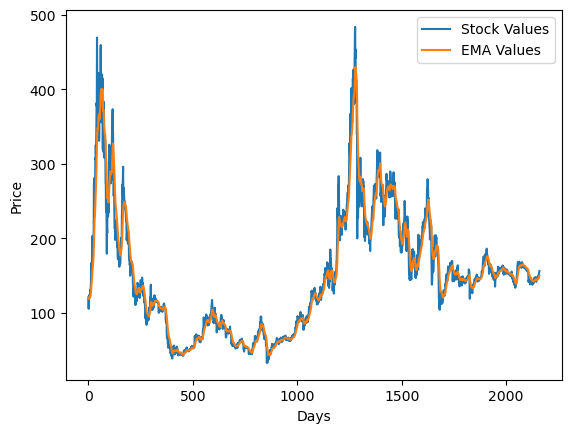

In [16]:
### Calculate EMA Indicator

ema = df['Close'].ewm(span=14, adjust=False).mean()
### Add EMA indicator to dataframe
df['EMA'] = ema

### Comparison plot b/w stock values & EMA
plt.plot(df['Close'], label="Stock Values")
plt.plot(ema, label="EMA Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show() 
### We can see that EMA index predicts out stock value (closing price) pretty good.

In [17]:
### Calculate Bollinger Band Indicator

sma = df['Close'].rolling(window=14).mean()
rstd = df['Close'].rolling(window=14).std()

upper_band = sma + 2 * rstd
lower_band = sma - 2 * rstd

### Option 1
### Calculate Band Width (Bollinger Band as single indicator)
# df['Band_Width'] = (upper_band - lower_band) / sma

### Option 2
### Calculate Bollinger band as separate indicators
df['Upper_Band'] = upper_band
df['Lower_Band'] = lower_band

In [18]:
### Calculate MACD Indicator

### Calculate Short-term (12 day) Exponential Moving Average (EMA)
short_term_ema = df['Close'].ewm(span=12, adjust=False).mean()

### Calculate Long-term (26 day) Exponential Moving Average (EMA)
long_term_ema = df['Close'].ewm(span=26, adjust=False).mean()

### Calculate MACD Line
macd = short_term_ema - long_term_ema

### Calculate Signal Line (9-day EMA of MACD)
signal_line = macd.ewm(span=9, adjust=False).mean()

### Add MACD and Signal Line to your DataFrame
df['MACD'] = macd
df['Signal_Line'] = signal_line

### Create a binary column for buy (1) and sell (0) signals
df['MACD_Signal'] = (df['MACD'] > df['Signal_Line']).astype(int)

In [19]:
### Plot Bollinger band Indicator and its upper/lower limits along with SMA and EMA indicators for Analysis purposes
 
df_chart = df.set_index('Date')
df_chart = df_chart[['Close']]

sma = df_chart.rolling(window=20).mean().dropna()
rstd = df_chart.rolling(window=20).std().dropna()
ema = df_chart[['Close']].ewm(span=20, adjust=False).mean().dropna()

upper_band = sma + 2 * rstd
lower_band = sma - 2 * rstd

upper_band = upper_band.rename(columns={'Close': 'upper'})
lower_band = lower_band.rename(columns={'Close': 'lower'})
bb = df_chart.join(upper_band).join(lower_band)
bb = bb.dropna()

buyers = bb[bb['Close'] <= bb['lower']]
sellers = bb[bb['Close'] >= bb['upper']]


### Plot begins here

pio.templates.default = "plotly_dark"

### Create figure
fig = go.Figure()

### Add lower_band to figure
fig.add_trace(go.Scatter(x=lower_band.index, 
                         y=lower_band['lower'], 
                         name='Lower Band', 
                         line_color='rgba(173,204,255,0.2)'
                        ))

### Add upper_band to figure
fig.add_trace(go.Scatter(x=upper_band.index, 
                         y=upper_band['upper'], 
                         name='Upper Band', 
                         fill='tonexty', 
                         fillcolor='rgba(173,204,255,0.2)', 
                         line_color='rgba(173,204,255,0.2)'
                        ))

### Add actual close price to figure
fig.add_trace(go.Scatter(x=df_chart.index, 
                         y=df_chart['Close'], 
                         name='Close', 
                         line_color='#636EFA'
                        ))

### Add SMA Indicator to figure
fig.add_trace(go.Scatter(x=sma.index, 
                         y=sma['Close'], 
                         name='SMA', 
                         line_color='#FECB52'
                        ))

### Add EMA Indicator to figure
fig.add_trace(go.Scatter(x=ema.index, 
                         y=ema['Close'], 
                         name='EMA', 
                         line_color='#FFFFFF'
                        ))

### Add buy oppurtunities to figure
fig.add_trace(go.Scatter(x=buyers.index, 
                         y=buyers['Close'], 
                         name='Buyers', 
                         mode='markers',
                         marker=dict(
                             color='#00CC96',
                             size=10,
                             )
                         ))

### Add sell oppurtunities to figure
fig.add_trace(go.Scatter(x=sellers.index, 
                         y=sellers['Close'], 
                         name='Sellers', 
                         mode='markers', 
                         marker=dict(
                             color='#EF553B',
                             size=10,
                             )
                         ))

# Limit X-axis to match our dataframe's date range (its index)
fig.update_xaxes(range=[df_chart.index.min(), df_chart.index.max()])

fig.show()

In [20]:
### Drop NaN values because of the nature of RSI, EMA, SMA and MACD calculations .
df.dropna(inplace=True)
### Reset Index
df.reset_index(drop=True, inplace=True)

### Assign features and target 
y = df['Price_Direction']
X = df.drop(columns=['Price_Direction', 'Date'])

In [21]:
### Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
### Split data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [23]:
### Use Grid Search for optimal K

param_grid = {
    'n_neighbors': range(1, 11)  
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 11)})

In [24]:
### Create and Train KNeighborsClassifier model 
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best n_neighbors(or k) by grid search is : {best_n_neighbors}\n")
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)

Best n_neighbors(or k) by grid search is : 5



KNeighborsClassifier()

In [25]:
y_predict = knn.predict(X_test)

In [26]:
### Performance Metrics for applied KNN algorithm on input data. 
f1 = f1_score(y_test, y_predict)
print(f"F1 score : {f1 * 100}")
print(f"Precision score : {precision_score(y_test, y_predict) * 100}")
print(f"Recall score : {recall_score(y_test, y_predict) * 100}")
print(f"AUC score : {roc_auc_score(y_test, y_predict) * 100}")

F1 score : 56.51214128035319
Precision score : 57.14285714285714
Recall score : 55.895196506550214
AUC score : 53.826995238199736


In [32]:
# Add some extra features (mostly from previous days)
df_expanded = df.copy()
n_days = 5
columns_to_drop = ['Date', 'Adj Close', 'Price_Direction']

for col in df_expanded.drop(columns_to_drop, axis=1).columns:
    for i in range(1, n_days + 1):
        df_expanded[col + f' Diff -{i}'] = (df_expanded[col].shift(i - 1) - df_expanded[col].shift(i))

for col in df_expanded.drop(columns_to_drop, axis=1).columns:
    if 'Diff' in col:
        for i in range(1, n_days + 1):
            df_expanded[col + f' Diff -{i}'] = (df_expanded[col].shift(i - 1) - df_expanded[col].shift(i))
            
df_expanded['CloseOpenDiff'] = df_expanded['Close'] - df_expanded['Open']
df_expanded['CloseLowDiff'] = df_expanded['Close'] - df_expanded['Low']
df_expanded['CloseHighDiff'] = df_expanded['Close'] - df_expanded['High']
df_expanded['VolumeCloseRatioDiff'] = df_expanded['Volume'] / df_expanded['Close']

            
df_expanded.dropna(inplace=True)
df_expanded.reset_index(drop=True, inplace=True)
        

In [33]:
# Train Test split
first_date_totest = '2023-09-08'
last_date_totest = '2023-10-07'
test = df_expanded[(df_expanded['Date'] >= first_date_totest) & (df_expanded['Date'] <= last_date_totest)]
train = df_expanded[df_expanded['Date'] < first_date_totest]

In [37]:
# Train and Find best Random Forest Clissifier model

y_train = train['Price_Direction'].values
columns_to_drop = list(filter(lambda col: not 'Diff' in col, train.columns.values))
features = train.drop(columns_to_drop, axis=1)
X_train = scaler.fit_transform(features)


params = {
    'n_estimators': [150, 250, 300, 350, 400],
    'max_depth': [2, 3],
    'class_weight': [None, 'balanced'],
    'max_features': ['auto', 'sqrt']
}

cv = StratifiedKFold(n_splits=5)
rfc = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(rfc, params, refit=True, cv=cv, scoring='f1_macro', verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best params : {best_params}\n")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params : {'class_weight': 'balanced', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 150}



              precision    recall  f1-score   support

           0       0.50      0.46      0.48      1001
           1       0.54      0.58      0.56      1095

    accuracy                           0.52      2096
   macro avg       0.52      0.52      0.52      2096
weighted avg       0.52      0.52      0.52      2096

ROC AUC score : 0.5200954296844708


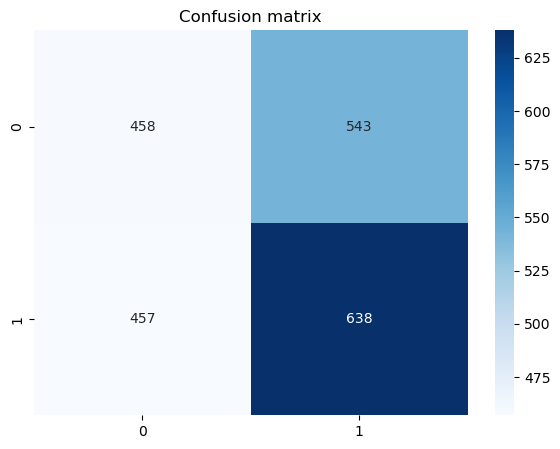

In [38]:
# Evaluate random forest model
rfc_best = RandomForestClassifier(random_state=0, **best_params)
y_preds = cross_val_predict(rfc_best, X_train, y_train, cv=cv)
print(classification_report(y_train, y_preds))
print(f"ROC AUC score : {roc_auc_score(y_train, y_preds)}")
cm = confusion_matrix(y_train, y_preds)
plt.figure(figsize=(7, 5))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

              precision    recall  f1-score   support

           0       0.50      0.58      0.54        12
           1       0.69      0.61      0.65        18

    accuracy                           0.60        30
   macro avg       0.59      0.60      0.59        30
weighted avg       0.61      0.60      0.60        30

ROC AUC score : 0.5972222222222222


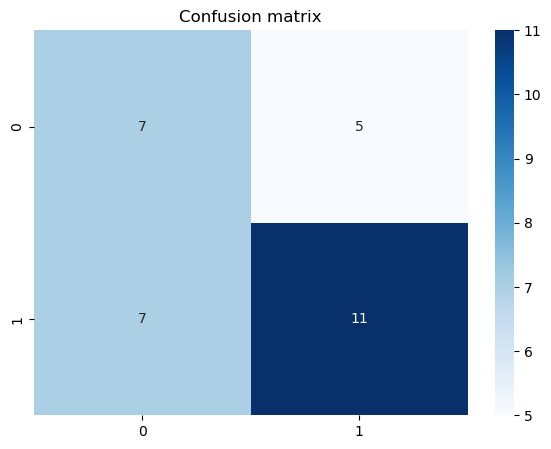

In [39]:
# Test on test set
y_preds = []
for _, row in test.iterrows():
    model = RandomForestClassifier(random_state=0, **best_params)
    model.fit(X_train, y_train)
    y_test = np.array([row['Price_Direction']])
    x_test = row[features.columns].values.reshape(1, -1)
    x_test = scaler.transform(x_test)
    y_pred = model.predict(x_test)
    y_preds.append(y_pred[0])
    X_train = np.concatenate((X_train, x_test), axis=0)
    y_train = np.concatenate((y_train, y_test), axis=0)
    
y_true = test['Price_Direction'].values
print(classification_report(y_true, y_preds))
print(f"ROC AUC score : {roc_auc_score(y_true, y_preds)}")
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(7, 5))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()